In [1]:
!wget https://www.dropbox.com/s/zbk1qindbgwhqoq/voc2019_harmonic.t7 -O voc2019_harmonic.t7

--2019-04-10 13:16:12--  https://www.dropbox.com/s/zbk1qindbgwhqoq/voc2019_harmonic.t7
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.1, 2620:100:6026:1::a27d:4601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zbk1qindbgwhqoq/voc2019_harmonic.t7 [following]
--2019-04-10 13:16:12--  https://www.dropbox.com/s/raw/zbk1qindbgwhqoq/voc2019_harmonic.t7
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbb2652e3344699a4c18895e194.dl.dropboxusercontent.com/cd/0/inline/Aeu-NUgahAs2SNTPIEQCIDeCfXlAmt2To7m8AH6mkbMk7-g1VOZLi0xZA3H4tdN_JR1xTS3Mfcp0OeVioYNisj8h1BxbDnWSuAWx_72rrZyfDA/file# [following]
--2019-04-10 13:16:13--  https://ucbb2652e3344699a4c18895e194.dl.dropboxusercontent.com/cd/0/inline/Aeu-NUgahAs2SNTPIEQCIDeCfXlAmt2To7m8AH6mkbMk7-g1VOZLi0xZA3H4tdN_JR1xTS3Mfcp0OeVioYNisj8h1BxbDnWSuAWx_72rrZyfDA/

In [18]:
import torch 
from torchvision import transforms
from harmonic import cluster
from models import PSPNet
from PIL import Image

class ResizePad(object):
    def __init__(self,size,interpolation=Image.BILINEAR,pad_value=0):
        self.desired_size = size
        self.interpolation = interpolation
        self.pad_value = pad_value

    def __call__(self, pil_image):
        old_size = pil_image.size  # old_size[0] is in (width, height) format
        ratio = float(self.desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])
        pil_image = pil_image.resize(new_size, resample=self.interpolation)
        # create a new image and paste the resized on it
        new_im = Image.new(pil_image.mode, (self.desired_size, self.desired_size),color=self.pad_value)
        new_im.paste(pil_image, ((self.desired_size-new_size[0])//2,
                            (self.desired_size-new_size[1])//2))
        return new_im

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

size=448
transform = transforms.Compose(
    [ResizePad(size,interpolation=Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

sins = [[6.71208381652832, 0.0, 0.297267347574234],
 [9.78760814666748, 0.0, 0.7205446362495422],
 [14.48250961303711, 0.0, 1.508858323097229],
 [-19.585268020629883, 0.0, 0.21253739297389984],
 [2.161958694458008, 0.0, 0.09481384605169296],
 [-13.258813858032227, 0.0, 0.5580582618713379],
 [0.0, -13.446259498596191, 0.7651816606521606],
 [0.0, -21.182514190673828, 1.7608462572097778],
 [0.0, -8.212303161621094, 1.011191725730896],
 [0.0, 19.381818771362305, -0.5626419186592102],
 [0.0, 8.32565689086914, 1.2664610147476196],
 [0.0, -16.503372192382812, 2.158210277557373]]


net = torch.nn.DataParallel(
    PSPNet(sins=sins,pretrained=False).to(device), [0]).to(device)

wdict = torch.load('voc2019_harmonic.t7')
for k in wdict.keys():
    if k.endswith('num_batches_tracked'):
        wdict.pop(k)
net.load_state_dict(wdict)
net.eval()
print("Model loaded")

Model loaded


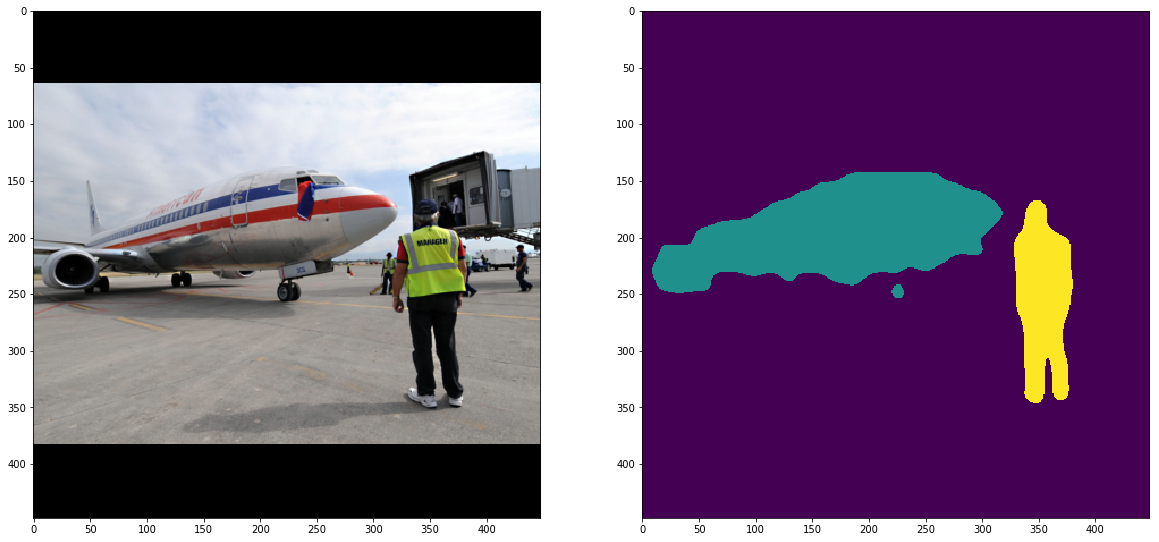

In [20]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img = Image.open("images/picture.jpg").convert('RGB')
#estimate the embeddings
x = transform(img)
emb = net(x.unsqueeze(0).to(device)).detach().cpu().numpy()
#cluster embeddings space
cc = cluster(emb[0],0.5,minimal_area=100)

f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(x.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225]+[0.485, 0.456, 0.406])
ax[1].imshow(cc)